# Project 2 – Group 34
## Dataset: Heart Failure Clinical Records
**Source:** [UCI Machine Learning Repository](https://doi.org/10.24432/C5Z89R)
 
> This dataset contains the medical records of 299 patients who experienced heart failure, collected during their follow-up period. Each patient profile includes 13 clinical features.

In [49]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# transformationer
def identity(x): return x
def log(x): return np.log(x + 1e-6)   # undgå log(0)
def sqrt(x): return np.sqrt(np.clip(x, 0, None))  # sqrt kræver >=0
def cbrt(x): return np.cbrt(x)        # kan håndtere negative
def reciprocal(x): return 1.0 / (x + 1e-6)  # undgå /0

## Classification: Baseline, Logistic Regression, and KNN
We will compare three classification methods on the heart failure dataset:
- Baseline (majority class)
- Logistic Regression (with regularization)
- k-Nearest Neighbors (KNN)
Performance will be evaluated using accuracy and cross-validation.

Loading and cleaning the dataset from the outcome of hand_in 1

In [50]:
df = pd.read_csv('../02452_Group34_Project1/data/heart_failure_clinical_records_dataset.csv')

X = df.drop(columns=['DEATH_EVENT', 'time'])         # Features without target and time
y = pd.Categorical(df['DEATH_EVENT'])        # Target as categorical

# Check the shape of the data
N, M = X.shape
assert N == 299, "There should be 299 samples in the Heart Failure dataset."
assert M == 11, "There should be 11 features in the Heart Failure dataset(13 together - target - time)"

#Transform the chosen features 
X_transformed = X.copy()
X_transformed['creatinine_phosphokinase'] = log(X_transformed['creatinine_phosphokinase'])
X_transformed['platelets'] = sqrt(X_transformed['platelets'])
X_transformed['serum_creatinine'] = reciprocal(X_transformed['serum_creatinine'])

X = X_transformed

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X = X_standardized

### 1. Classification Problem Statement
We are solving a **binary classification problem**: predicting whether a patient died during the follow-up period (`DEATH_EVENT` = 1) or survived (`DEATH_EVENT` = 0). The target variable is binary, so this is not a multi-class problem.

we are gonna do baseline, logistic regression and KNN, in the code nlock bellow we make just first draft of classifier with random paramters

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Baseline: predict the majority class
def baseline_accuracy(y):
    majority_class = y.value_counts().idxmax()
    y_pred_baseline = np.full_like(y, majority_class)
    return accuracy_score(y, y_pred_baseline)

baseline_acc = baseline_accuracy(y)
print(f'Baseline accuracy (majority class): {baseline_acc:.3f}')

# Logistic Regression with regularization (lambda = C^-1)
logreg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
print(f'Logistic Regression CV accuracy: {logreg_scores.mean():.3f} ± {logreg_scores.std():.3f}')

# KNN classification (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print(f'KNN (k=5) CV accuracy: {knn_scores.mean():.3f} ± {knn_scores.std():.3f}')

Baseline accuracy (majority class): 0.679
Logistic Regression CV accuracy: 0.736 ± 0.069
KNN (k=5) CV accuracy: 0.676 ± 0.034


They do not perform the best, so from first simple classification Logistic regression for classfication performs the best, lets do some cross-validation so tune the paramters

### 2. Models and Complexity Parameters
- **Logistic Regression**: We use the regularization parameter λ (lambda) to control model complexity. In scikit-learn, this is set via `C = 1/λ`. We will test values such as λ ∈ {0.01, 0.05, 0.1, 0.5, 1.0} (i.e., C ∈ {100, 20, 10, 2, 1}).
- **Method 2 (KNN)**: The complexity parameter is the number of neighbors, k. We will test k ∈ {1, 3, 5, 7, 9}.
- **Baseline**: Always predicts the majority class in the training data.

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Outer and inner cross-validation folds
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Parameter grids for models
logreg_param_grid = {'C': [100, 20, 10, 2, 1]}
knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Store results
results_list = []
y_true_outer, y_pred_logreg_outer, y_pred_knn_outer = [], [], []

# Outer cross-validation loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Baseline Model ---
    majority_class = np.argmax(np.bincount(y_train))
    y_pred_baseline = np.full_like(y_test, majority_class)
    E_baseline = 1 - accuracy_score(y_test, y_pred_baseline)

    # --- Logistic Regression: Manual Inner CV for Best C ---
    logreg_val_errors = {}
    for C_val in logreg_param_grid['C']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            model = LogisticRegression(penalty='l2', C=C_val, solver='liblinear', max_iter=1000)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
        logreg_val_errors[C_val] = np.mean(inner_errors)
    
    best_C = min(logreg_val_errors, key=logreg_val_errors.get)
    
    # Train final LogReg model on outer train set with best C
    final_logreg = LogisticRegression(penalty='l2', C=best_C, solver='liblinear', max_iter=1000)
    final_logreg.fit(X_train, y_train)
    y_pred_logreg = final_logreg.predict(X_test)
    E_logreg = 1 - accuracy_score(y_test, y_pred_logreg)

    # --- KNN: Manual Inner CV for Best k ---
    knn_val_errors = {}
    for k_val in knn_param_grid['n_neighbors']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            model = KNeighborsClassifier(n_neighbors=k_val)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
        knn_val_errors[k_val] = np.mean(inner_errors)

    best_k = min(knn_val_errors, key=knn_val_errors.get)

    # Train final KNN model on outer train set with best k
    final_knn = KNeighborsClassifier(n_neighbors=best_k)
    final_knn.fit(X_train, y_train)
    y_pred_knn = final_knn.predict(X_test)
    E_knn = 1 - accuracy_score(y_test, y_pred_knn)

    # Append results for this fold
    results_list.append([fold, best_k, E_knn, best_C, E_logreg, E_baseline])
    
    # Store predictions for statistical analysis
    y_true_outer.extend(y_test)
    y_pred_logreg_outer.extend(y_pred_logreg)
    y_pred_knn_outer.extend(y_pred_knn)

# Create a DataFrame for the results
results_df = pd.DataFrame(results_list, columns=['Fold', 'Best k', 'KNN Error', 'Best C', 'LogReg Error', 'Baseline Error'])
results_df

,Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.266667,100,0.366667,0.333333
1,2,9,0.266667,1,0.366667,0.333333
2,3,9,0.400000,1,0.300000,0.333333
3,4,1,0.433333,100,0.233333,0.333333
4,5,5,0.333333,100,0.266667,0.333333
5,6,7,0.333333,100,0.366667,0.333333
6,7,9,0.233333,1,0.033333,0.300000
7,8,9,0.366667,100,0.200000,0.300000
8,9,7,0.366667,100,0.233333,0.300000
9,10,9,0.275862,100,0.206897,0.310345


### 3. Two-Level Cross-Validation and Error Table
We use nested cross-validation to select the best parameters and estimate test error. The outer loop splits the data for testing, and the inner loop selects the best parameter value. The error rate is computed as:
$$ E = \frac{\text{Number of misclassified observations}}{N_{\text{test}}} $$
The results are summarized in a table similar to Table 2, showing the selected parameters and error rates for each fold.

Results from Nested Cross-Validation:


,Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.266667,100,0.366667,0.333333
1,2,9,0.266667,1,0.366667,0.333333
2,3,9,0.400000,1,0.300000,0.333333
3,4,1,0.433333,100,0.233333,0.333333
4,5,5,0.333333,100,0.266667,0.333333
5,6,7,0.333333,100,0.366667,0.333333
6,7,9,0.233333,1,0.033333,0.300000
7,8,9,0.366667,100,0.200000,0.300000
8,9,7,0.366667,100,0.233333,0.300000
9,10,9,0.275862,100,0.206897,0.310345


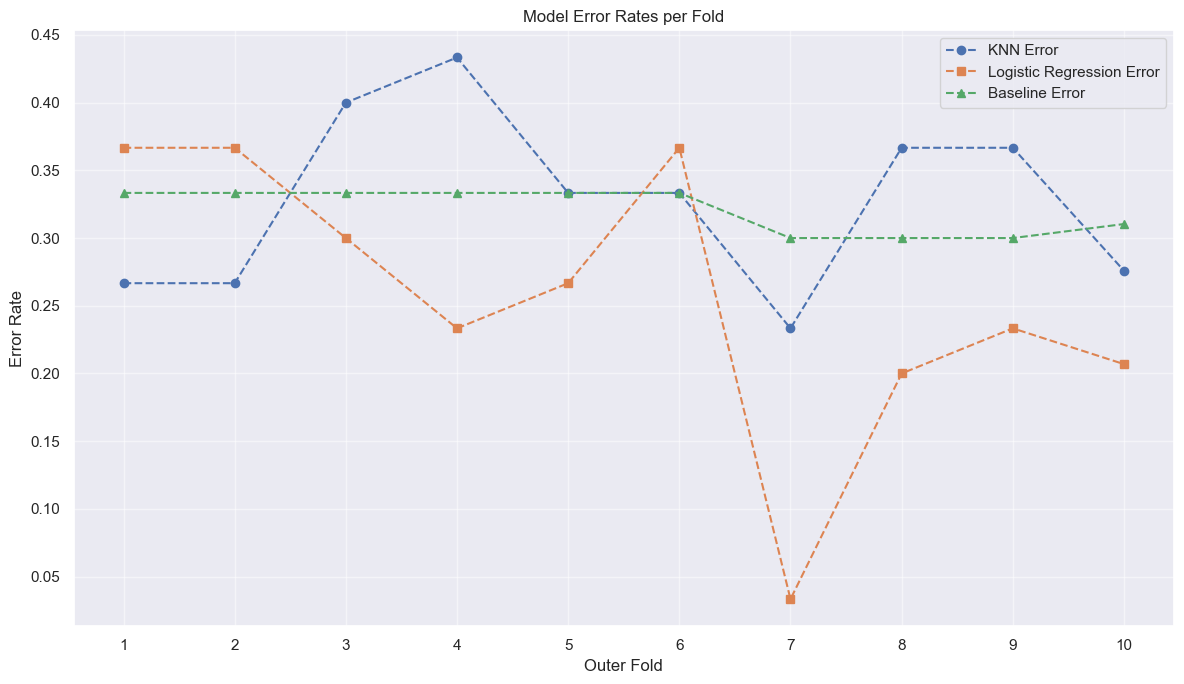

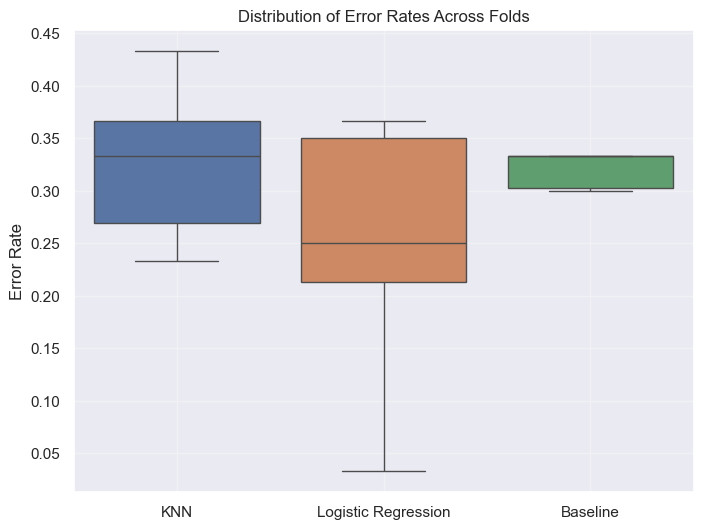

In [53]:
# Display the results table
print("Results from Nested Cross-Validation:")
display(results_df)

# --- Visualize Error Rates ---
plt.figure(figsize=(12, 7))

# Plot error rates per fold
plt.plot(results_df['Fold'], results_df['KNN Error'], marker='o', linestyle='--', label='KNN Error')
plt.plot(results_df['Fold'], results_df['LogReg Error'], marker='s', linestyle='--', label='Logistic Regression Error')
plt.plot(results_df['Fold'], results_df['Baseline Error'], marker='^', linestyle='--', label='Baseline Error')

plt.title('Model Error Rates per Fold')
plt.xlabel('Outer Fold')
plt.ylabel('Error Rate')
plt.xticks(results_df['Fold'])
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- Boxplot of Error Rates ---
plt.figure(figsize=(8, 6))
error_df = pd.DataFrame({
    'KNN': results_df['KNN Error'],
    'Logistic Regression': results_df['LogReg Error'],
    'Baseline': results_df['Baseline Error']
})
sns.boxplot(data=error_df)
plt.title('Distribution of Error Rates Across Folds')
plt.ylabel('Error Rate')
plt.grid(True, alpha=0.3)
plt.show()